# Head model and forward computation

This is an example of creating a BEM forward head model with a real geometry.


Initialize mne python

In [1]:
%matplotlib qt
import mne
from mne.datasets import sample

Define the file containing the data we will use.
We will need:
- A source space
- BEM surfaces.
- Coregistration information (how sensors are related to MR images).

In [2]:
data_path = sample.data_path()
# the raw file containing the channel location + types
sample_dir = data_path / "MEG" / "sample"
raw_fname = sample_dir / "sample_audvis_raw.fif"
# The paths to Freesurfer reconstructions
subjects_dir = data_path / "subjects"
subject = "sample"

# Compute and visualize BEM surfaces

BEM surfaces define interfaces between tissues of different conductivities.
They are give as meshes. 
These surfaces are for example the inner skull surface, the outer skull surface and the outer skin surface, a.k.a. scalp surface.

Computing the BEM surfaces requires FreeSurfer and makes use of the command-line tools mne watershed_bem or mne flash_bem, or the related functions mne.bem.make_watershed_bem() or mne.bem.make_flash_bem().
See next part of the course.
Here, we will assume the surfaces are given.

For EEG we use 3 layers (inner skull, outer skull, and skin) while for MEG 1 layer (inner skull) is enough.

In [ ]:
plot_bem_kwargs = dict(
    subject=subject, subjects_dir=subjects_dir,
    brain_surfaces='white', orientation='coronal',
    slices=[50, 100, 150, 200])

mne.viz.plot_bem(**plot_bem_kwargs)

# Visualizing the coregistration

Coregistration aims at putting evereything (sources, surfaces, sensors) in a same geometrical model.
This requires some work from the expetimenter.
Here again, we assume that the co-registration has already been made and is given.

In [4]:
# The transformation file obtained by coregistration
trans = sample_dir / "sample_audvis_raw-trans.fif"

info = mne.io.read_info(raw_fname)


    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle


In [5]:
# Here we look at the dense head, which isn't used for BEM computations but
# is useful for coregistration.
mne.viz.plot_alignment(info, trans, subject=subject, dig=True,
                       meg=['helmet', 'sensors'], subjects_dir=subjects_dir,
                       surfaces='head-dense')

Using pyvistaqt 3d backend.

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Using lh.seghead for head surface.


/user/papadop/home/.local/lib/python3.11/site-packages/pyvista/plotting/plotting/__init__.py:23: PyVistaDeprecationWarning: The `pyvista.plotting.plotting` module has been deprecated. `_ALL_PLOTTERS` is now imported as: `from pyvista.plotting import _ALL_PLOTTERS`.
  warnings.warn(


Getting helmet for system 306m
Channel types::	grad: 203, mag: 102, eeg: 59


# Compute Source Space

The source space is given as a set of positions and orientations of dipoles.
First use a surfacic repartition for sources.

In [6]:
src = mne.setup_source_space(subject, spacing='oct4', add_dist='patch',
                             subjects_dir=subjects_dir)
print(src)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /user/papadop/home/mne_data/MNE-sample-data/subjects
Subject      = sample
Surface      = white
Octahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/surf/lh.white...
Mapping lh sample -> oct (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 258/155407 selected to source space (oct = 4)

Loading /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/surf/rh.white...
Mapping rh sample -> oct (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 

Visualize the source space.

Using surface: /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/bem/inner_skull.surf
Using surface: /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/bem/outer_skull.surf
Using surface: /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/bem/outer_skin.surf


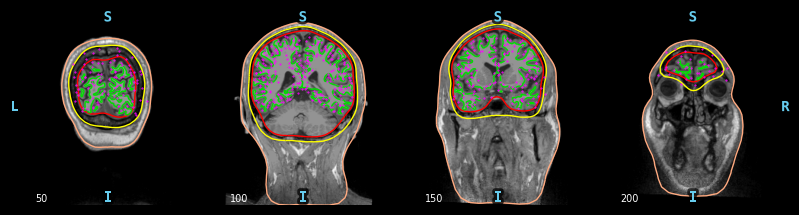

In [7]:
mne.viz.plot_bem(src=src, **plot_bem_kwargs)

Volume based repartition. A grid of candidate dipoles inside a sphere sphere of radius 90mm centered at (0.0, 0.0, 40.0) mm. Not perfect as some sources are outside of the brain or even the head and parts of the cortex might not becovered (with smaller radiuses).

Sphere                : origin at (0.0 0.0 40.0) mm
              radius  : 90.0 mm
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/mri/T1.mgz

Reading /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/mri/T1.mgz...

Setting up the sphere...
Surface CM = (   0.0    0.0   40.0) mm
Surface fits inside a sphere with radius   90.0 mm
Surface extent:
    x =  -90.0 ...   90.0 mm
    y =  -90.0 ...   90.0 mm
    z =  -50.0 ...  130.0 mm
Grid extent:
    x =  -95.0 ...   95.0 mm
    y =  -95.0 ...   95.0 mm
    z =  -50.0 ...  135.0 mm
57798 sources before omitting any.
24365 sources after omitting infeasible sources not within 0.0 - 90.0 mm.
20377 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.
Source space : MRI voxel -> MRI (surface RAS)
     0.005000  0.000000  0.000000     -95.00 mm
     0.000000  0.

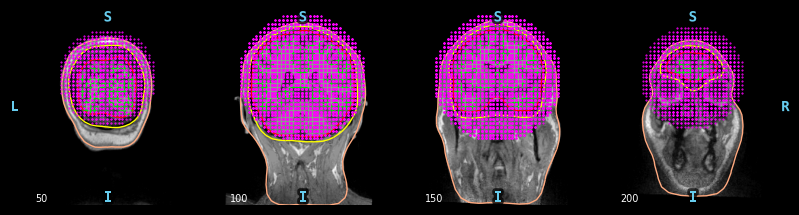

In [8]:
sphere = (0.0, 0.0, 0.04, 0.09)
vol_src = mne.setup_volume_source_space(
    subject, subjects_dir=subjects_dir, sphere=sphere, sphere_units='m',
    add_interpolator=False)  # just for speed!
print(vol_src)

mne.viz.plot_bem(src=vol_src, **plot_bem_kwargs)

Restrict sources to be in the brain.

Boundary surface file : /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/bem/inner_skull.surf
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/mri/T1.mgz

Reading /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/mri/T1.mgz...

Loaded bounding surface from /user/papadop/home/mne_data/MNE-sample-data/subjects/sample/bem/inner_skull.surf (2562 nodes)
Surface CM = (   0.7  -10.0   44.3) mm
Surface fits inside a sphere with radius   91.8 mm
Surface extent:
    x =  -66.7 ...   68.8 mm
    y =  -88.0 ...   79.0 mm
    z =  -44.5 ...  105.8 mm
Grid extent:
    x =  -70.0 ...   70.0 mm
    y =  -90.0 ...   80.0 mm
    z =  -45.0 ...  110.0 mm
32480 sources before omitting any.
22941 sources after omitting infeasible sources not within 0.0 - 91.8 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found   846/10797 points outside using solid angles
    Total 12738/22941 points inside the surface
Interior check completed in 4944.0 ms
    10203 source space points omitted because they are outside the inner skull surface.
    2362 source space points omitted because of the    5.0-mm distance limit.
10376 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.
Source space : MRI voxel -> MRI (surface RAS)
     0.005000  0.000000  0.000000     -70.00 mm
     0.000000  0.005000  0.000000     -90.00 mm
     0.000000  0.000000  0.005000     -45.00 mm
     0.000000  0.000000  0.000000       1.00
MRI volume : MRI voxel -> MRI (surface RAS)
    -0.001000  0.000000  0.000000     128.00 mm
     0.000000  0.000000  0.001000    -128.00 mm
     0.000000 -0.001000  0.000000     128.00 mm
     0.000000  0.000000  0.000000       1.00
MRI volume : MRI (surface RAS) -> RAS (non-zero origin)
     1.000000 -0.000000 -0.0000

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


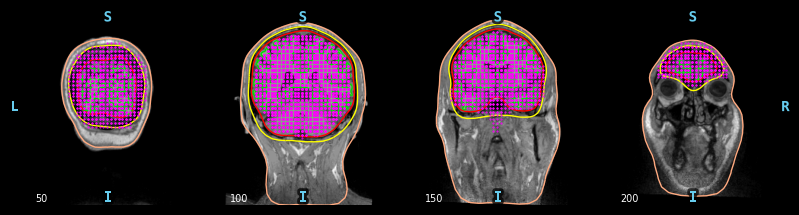

In [9]:
surface = subjects_dir / subject / "bem" / "inner_skull.surf"
vol_src = mne.setup_volume_source_space(
    subject, subjects_dir=subjects_dir, surface=surface,
    add_interpolator=False)  # Just for speed!
print(vol_src)

mne.viz.plot_bem(src=vol_src, **plot_bem_kwargs)

View all sources in 3D.

In [10]:
fig = mne.viz.plot_alignment(subject=subject, subjects_dir=subjects_dir,
                             surfaces='white', coord_frame='mri',
                             src=src)
mne.viz.set_3d_view(fig, azimuth=173.78, elevation=101.75,
                    distance=0.30, focalpoint=(-0.03, -0.01, 0.03))

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


# Compute forward solution

We can now compute the forward solution. To reduce computation we’ll just compute a single layer BEM (just inner skull) that can then be used for MEG (not EEG). We specify if we want a one-layer or a three-layer BEM using the conductivity parameter. The BEM solution requires a BEM model which describes the geometry of the head the conductivities of the different tissues.

In [11]:
conductivity = (0.3,)  # for single layer
# conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(subject='sample', ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
inner skull CM is   0.67 -10.01  44.26 mm
Surfaces passed the basic topology checks.
Complete.

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


This model only depends on the head geometry and conductivities. It is therefore independent from the MEG data and the head position.

Let’s now compute the forward operator, commonly referred to as the gain or leadfield matrix.

In [12]:
fwd = mne.make_forward_solution(raw_fname, trans='fsaverage', src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=1,
                                verbose=True)
print(fwd)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=258>, <surface (rh), n_vertices=156866, n_used=258>] MRI (surface RAS) coords, subject 'sample', ~28.7 MB>
MRI -> head transform : /usr/lib/python3.11/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : sample_audvis_raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 516 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
     0.991420 -0.039936 -0.124467      -6.13 mm
     0.060661  0.984012  0.167456       0.06 mm
     0.115790 -0.173570  0.9

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Computing MEG at 474 source locations (free orientations)...

Finished.
<Forward | MEG channels: 306 | EEG channels: 0 | Source space: Surface with 474 vertices | Source orientation: Free>


Forward computation can remove vertices that are too close to (or outside) the inner skull surface. For example, here we have gone from 516 to 474 vertices in use. 

In [13]:
print(f'Before: {src}')
print(f'After:  {fwd["src"]}')

Before: <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=258>, <surface (rh), n_vertices=156866, n_used=258>] MRI (surface RAS) coords, subject 'sample', ~28.7 MB>
After:  <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=235>, <surface (rh), n_vertices=156866, n_used=239>] head coords, subject 'sample', ~28.7 MB>


We can explore the content of fwd to access the numpy array that contains the gain matrix.

In [14]:
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 306 sensors x 1422 dipoles


To extract the numpy array containing the forward operator corresponding to the source space fwd['src'] with cortical orientation constraint we can use the following:

In [15]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)
leadfield = fwd_fixed['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Leadfield size : 306 sensors x 474 dipoles


This is equivalent to the following code that explicitly applies the forward operator to a source estimate composed of the identity operator (which we omit here because it uses a lot of memory):

In [16]:
import numpy as np
n_dipoles = leadfield.shape[1]
vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]
stc = mne.SourceEstimate(1e-9 * np.eye(n_dipoles), vertices,tmin=0, tstep=0.01)
leadfield = mne.apply_forward(fwd_fixed, stc, info).data / 1e-9

Projecting source estimate to sensor space...
[done]


To save to disk a forward solution you can use mne.write_forward_solution() and to read it back from disk mne.read_forward_solution(). 

FIF files containing forward solution should end with -fwd.fif.

In [ ]:
print(leadfield)

In [17]:
print(leadfield.shape)

(306, 474)
